<IPython.core.display.Javascript object>


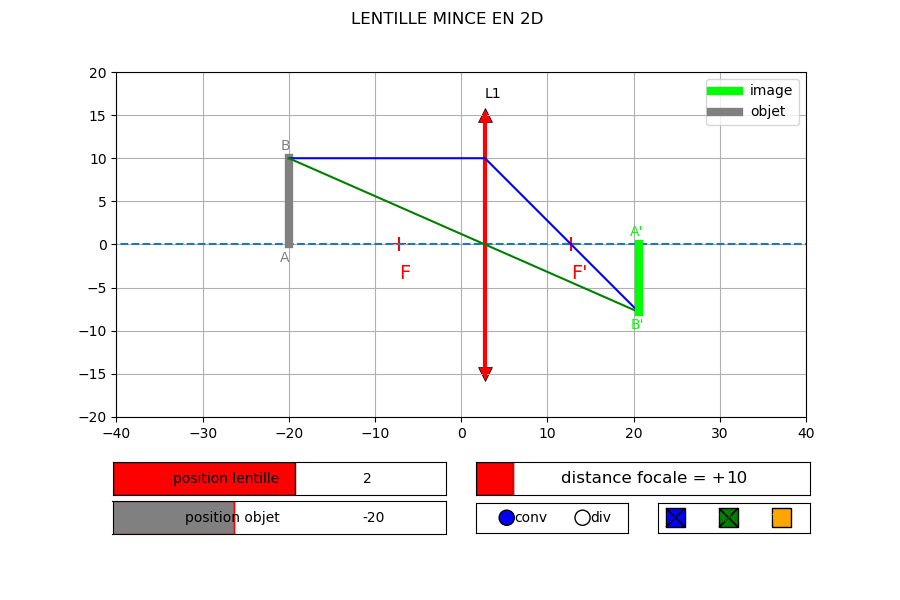

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.widgets import Slider,AxesWidget
from matplotlib.patches import Circle, Rectangle

class CheckButtonsH(AxesWidget):
   
    def __init__(self, ax, labels, actives):
       
        AxesWidget.__init__(self, ax)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_navigate(False)
        dx = 10. / (len(labels)+1 )
        xs = np.linspace( dx,12- dx, len(labels))
        
        cnt = 0
        axcolor = ax.get_facecolor()

        self.labels = []
        self.lines = []
        self.rectangles = []
        
        couls=["blue","green","orange"]
        lineparams = {'color': 'k', 'linewidth': 1.25, 'solid_capstyle': 'butt'}
        for x, label in zip(xs, labels):
            t = ax.text(x-2,1, label,color=couls[cnt],horizontalalignment='left',verticalalignment='center')

            w, h = dx / 2., dx / 2.
            x, y = x-2, 1 - h / 2.

            p = Rectangle(xy=(x, y),fill=True, width=w, height=h, edgecolor='black',facecolor=couls[cnt])

            l1 = plt.Line2D([x, x + w], [y + h, y], **lineparams)
            l2 = plt.Line2D([x, x + w], [y, y + h], **lineparams)

            l1.set_visible(actives[cnt])
            l2.set_visible(actives[cnt])
            self.labels.append(t)
            self.rectangles.append(p)
            self.lines.append((l1, l2))
            ax.add_patch(p)
            ax.add_line(l1)
            ax.add_line(l2)
            cnt += 1

        self.connect_event('button_press_event', self._clicked)

        self.cnt = 0
        self.observers = {}

    def _clicked(self, event):
        if self.ignore(event):
            return
        if event.button != 1:
            return
        if event.inaxes != self.ax:
            return

        for i, (p, t) in enumerate(zip(self.rectangles, self.labels)):
            if (t.get_window_extent().contains(event.x, event.y) or
                    p.get_window_extent().contains(event.x, event.y)):
                self.set_active(i)
                break
        else:
            return

    def set_active(self, index):
        """
        Directly (de)activate a check button by index.

        *index* is an index into the original label list
            that this object was constructed with.
            Raises ValueError if *index* is invalid.

        Callbacks will be triggered if :attr:`eventson` is True.

        """
        if 0 > index >= len(self.labels):
            raise ValueError("Invalid CheckButton index: %d" % index)

        l1, l2 = self.lines[index]
        l1.set_visible(not l1.get_visible())
        l2.set_visible(not l2.get_visible())

        if self.drawon:
            self.ax.figure.canvas.draw()

        if not self.eventson:
            return
        for cid, func in six.iteritems(self.observers):
            func(self.labels[index].get_text())

    def get_status(self):
        """
        returns a tuple of the status (True/False) of all of the check buttons
        """
        return [l1.get_visible() for (l1, l2) in self.lines]

    def on_clicked(self, func):
        """
        When the button is clicked, call *func* with button label

        A connection id is returned which can be used to disconnect
        """
        cid = self.cnt
        self.observers[cid] = func
        self.cnt += 1
        return cid

    def disconnect(self, cid):
        """remove the observer with connection id *cid*"""
        try:
            del self.observers[cid]
        except KeyError:
            pass


# classe mofifiée
class RadioButtonsH(AxesWidget):
    
    def __init__(self, ax, labels, active=0, activecolor='blue'):
       
        AxesWidget.__init__(self, ax)
        self.activecolor = activecolor
        self.value_selected = None

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_navigate(False)
        dx = 10. / (len(labels) )
        xs = np.linspace(5 - dx+2, dx+2, len(labels))
        #dy = 1. / (len(labels) + 1)
        #ys = np.linspace(1 - dy, dy, len(labels))
        cnt = 0
        axcolor = ax.get_facecolor()

        self.labels = []
        self.circles = []
        for x, label in zip(xs, labels):
            t = ax.text(x+0.5, 1, label, horizontalalignment='left', verticalalignment='center')

            if cnt == active:
                self.value_selected = label
                facecolor = activecolor
            else:
                facecolor = axcolor
            #print("x=",x)

            p = Circle(xy=(x, 1), radius=0.5, edgecolor='black',
                       facecolor=facecolor)

            self.labels.append(t)
            self.circles.append(p)
            ax.add_patch(p)
            cnt += 1

        self.connect_event('button_press_event', self._clicked)

        self.cnt = 0
        self.observers = {}

    def _clicked(self, event):
        if self.ignore(event):
            return
        if event.button != 1:
            return
        if event.inaxes != self.ax:
            return
        xy = self.ax.transAxes.inverted().transform_point((event.x, event.y))
        xy = (event.x, event.y)
        pclicked = np.array([xy[0], xy[1]])
        #print("eventX=",event.x)

        def inside(p):
            pcirc = np.array([p.center[0], p.center[1]])
            print("distance=",dist(pclicked, pcirc))
            return dist(pclicked, pcirc) < p.radius

        for i, (p, t) in enumerate(zip(self.circles, self.labels)):
            if t.get_window_extent().contains(event.x, event.y) or inside(p):
                self.set_active(i)
                #print("i=",i)
                break
        else:
            return

    def set_active(self, index):
        
        if 0 > index >= len(self.labels):
            raise ValueError("Invalid RadioButton index: %d" % index)

        self.value_selected = self.labels[index].get_text()

        for i, p in enumerate(self.circles):
            if i == index:
                color = self.activecolor
            else:
                color = self.ax.get_facecolor()
            p.set_facecolor(color)

        if self.drawon:
            self.ax.figure.canvas.draw()

        if not self.eventson:
            return
        for cid, func in six.iteritems(self.observers):
            func(self.labels[index].get_text())

    def on_clicked(self, func):
        """
        When the button is clicked, call *func* with button label

        A connection id is returned which can be used to disconnect
        """
        cid = self.cnt
        self.observers[cid] = func
        self.cnt += 1
        return cid

    def disconnect(self, cid):
        """remove the observer with connection id *cid*"""
        try:
            del self.observers[cid]
        except KeyError:
            pass

class Lentille:
    def __init__(self,ax, rayon=15, focale=10, posx=0,bord="conv",vue=True,label="L1"):
        self.bord=bord
        self.label=label
        self.text_label=ax.text(posx,rayon+2,label)
        self.rayon=rayon
        self.focale=focale
        self.posx=posx
        self.ligne=plt.Line2D((posx,posx),(-rayon,rayon), color='red',lw=3) # arrow line
        ax.add_artist(self.ligne)
        self.boutB=ax.scatter(posx,-rayon,s=100, c='red',marker='v',edgecolors='k',linewidths=1) # lower arrowhead
        self.boutH=ax.scatter(posx, rayon,s=100, c='red',marker='^',edgecolors='k',linewidths=1) # upper arrowhead
        self.pos_foyer1=ax.scatter(posx-focale, 0,s=100, c='red',marker='+',edgecolors='k',linewidths=0.5) # upper arrowhead
        self.pos_foyer2=ax.scatter(posx+focale, 0,s=100, c='red',marker='+',edgecolors='k',linewidths=0.5) 
        self.label_foyer1=ax.text(posx-focale, -4,s='F', color='red',fontsize=20)
        self.label_foyer2=ax.text(posx+focale, -4,s="F'", color='red',fontsize=20)
        self.tracer_lentille(axe)
        
        
    def tracer_lentille(self,ax):
        rayon=self.rayon
        focale=self.focale
        posx=self.posx
        bord=self.bord
        self.ligne.set_xdata((posx,posx))
        self.ligne.set_ydata((-rayon,rayon)) # arrow line
        self.text_label.set_x(posx)
        self.text_label.set_y(rayon+2)
        self.boutB.remove()
        self.boutH.remove()
        if(bord=="conv"):
            self.boutB=ax.scatter(posx,-rayon,s=100, c='red',marker='v',edgecolors='k',linewidths=0.5) # lower arrowhead
            self.boutH=ax.scatter(posx, rayon,s=100, c='red',marker='^',edgecolors='k',linewidths=0.5) # upper arrowhead
        else:
            self.boutB=ax.scatter(posx,-rayon,s=100, c='red',marker='^',edgecolors='k',linewidths=0.5) # lower arrowhead
            self.boutH=ax.scatter(posx, rayon,s=100, c='red',marker='v',edgecolors='k',linewidths=0.5) # upper arrowhead
        self.pos_foyer1.remove()
        self.pos_foyer2.remove()
        self.pos_foyer1=ax.scatter(posx-focale, 0,s=100, c='red',marker='+',edgecolors='k',linewidths=0.5) # upper arrowhead
        self.pos_foyer2=ax.scatter(posx+focale, 0,s=100, c='red',marker='+',edgecolors='k',linewidths=0.5) 
        self.label_foyer1.remove()
        self.label_foyer2.remove()
        #if(nature=="conv"):
        self.label_foyer1=ax.text(posx-focale, -4,s='F', color='red',fontsize=14)
        self.label_foyer2=ax.text(posx+focale, -4,s="F'", color='red',fontsize=14)
  
    def voir_lentille(self,vue=True):
        self.ligne.set_visible(vue)
        self.boutB.set_visible(vue)
        self.boutH.set_visible(vue)
        self.pos_foyer1.set_visible(vue)
        self.pos_foyer2.set_visible(vue)
        self.label_foyer1.set_visible(vue)
        self.label_foyer2.set_visible(vue)
        self.text_label.set_visible(vue)
        
    
    
class Objet:
    def __init__(self,ax, haut=10,  posx=-20,label="objet AB"):
        self.alpha=None
        self.haut=haut
        self.posx=posx
        self.label=label
        self.nature="reel"
        self.legend_objet1=ax.text(posx-1,haut,"B",color="grey",clip_on=True)
        self.legend_objet2=ax.text(posx-1,0,"A",color="grey",clip_on=True)

    def set_position(self,val):
        self.posx=val     
    
    def tracer_objet(self):
        posx_obj=self.posx
        haut_obj=self.haut
        objet_plot.set_xdata([posx_obj,posx_obj])   #arrow line
        objet_plot.set_ydata([0,haut_obj])
        self.legend_objet1.set_x(posx_obj-1)
        self.legend_objet1.set_y(haut_obj+1)
        self.legend_objet1.set_text("B")
        self.legend_objet2.set_x(posx_obj-1)
        self.legend_objet2.set_y(-2)
        self.legend_objet2.set_text("A")
        
class Image1:
    def __init__(self,ax, objet,lentille,haut=5,posx=10,label="image"):
        self.label=label
        #self.text_label=ax.text(posx,haut+2,label)
        self.obj=objet
        self.lent=lentille
        
        self.posx=posx
        self.haut=haut
        self.nature="reelle"
        self.legend_image1=ax.text(posx-1,-2,"A'",color="lime",clip_on=True)
        self.legend_image2=ax.text(posx-1,haut+1,"B'",color="lime",clip_on=True)
        self.calculer_image()
        
       
    def set_position(self,val):
        self.posx=val
    
    def calculer_image(self):    
        bord=self.lent.bord
        posx_img=0
        haut_img=0
        if(bord=="conv"):
            posx_img,haut_img=self.calculer_image_conv()
        else:
            posx_img,haut_img=self.calculer_image_div()
        return posx_img,haut_img
        
    def calculer_image_conv(self):
        rayon=self.lent.rayon
        posx_lent=self.lent.posx
        posx_obj=self.obj.posx
        haut_obj=self.obj.haut
        alpha=self.obj.alpha
        line11.set_visible(False)
        line22.set_visible(False)
        borne1,borne2=axe.get_xlim()
        foc=self.lent.focale
        d1=posx_obj-posx_lent
        if(alpha ==-10):
            posx_img=posx_lent+foc
            haut_img=foc*np.tan(np.deg2rad(alpha))
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image2.set_x(posx_img-1)
            if (haut_img>0.0):
                self.legend_image2.set_y(haut_img+2)
                self.legend_image1.set_y(-1)
            else:
                self.legend_image1.set_y(+1)
                self.legend_image2.set_y(haut_img-2)
            posy_borne1=(borne1-posx_lent)*np.tan(np.deg2rad(alpha))
            line1.set_xdata([borne1,posx_lent,posx_img])
            line1.set_ydata([posy_borne1+5,5,haut_img])
            line2.set_xdata([borne1,posx_img])
            line2.set_ydata([posy_borne1,haut_img])
            
        elif (d1==0):
            self.nature="fixe"
            posx_img=posx_obj
            haut_img=haut_obj
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(-2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img+2)
            
            line1.set_xdata([posx_obj,posx_obj])
            line1.set_ydata([haut_obj,haut_obj])
            line2.set_xdata([posx_obj,posx_obj])
            line2.set_ydata([haut_obj,haut_obj])
           
        elif (d1<-foc):               #objet réel image réel
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            self.nature="reelle"
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image2.set_x(posx_img-1)
            if (haut_img>0.0):
                self.legend_image2.set_y(haut_img+2)
                self.legend_image1.set_y(-1)
            else:
                self.legend_image1.set_y(+1)
                self.legend_image2.set_y(haut_img-2)
            line1.set_xdata([posx_obj,posx_lent,posx_img])
            line1.set_ydata([haut_obj,haut_obj,haut_img])
            line2.set_xdata([posx_obj,posx_img])
            line2.set_ydata([haut_obj,haut_img])
        elif (d1==-foc):            #image à l'infini
            posx_img=-np.inf
            haut_img=-np.inf
            self.nature=("moins_infinie")
            self.obj.nature="reel"
            image_plot.set_xdata([])
            image_plot.set_ydata([])
            line2.set_xdata([posx_lent+4*d1,posx_lent-2*d1])
            line2.set_ydata([4*haut_obj,-2*haut_obj])
            line1.set_xdata([posx_obj,posx_lent,posx_lent-2*d1])
            line1.set_ydata([haut_obj,haut_obj,-haut_obj])
            line11.set_xdata([posx_lent,posx_lent+4*d1])
            line11.set_ydata([haut_obj,5*haut_obj])
            line11.set_visible(True)
            #line1=plt.Line2D([2*posx_obj,-2*posx_obj],[2*haut_obj,-2*haut_obj])
            #line2=plt.Line2D([2*posx_obj,-2*posx_obj],[3*haut_obj,-haut_obj])
        elif (d1<0 and d1>-foc):   #image virtuelle
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            self.nature=("virtuelle")
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(-2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img+1)
            line1.set_xdata([posx_obj,posx_lent,posx_lent+2*foc])
            line1.set_ydata([haut_obj,haut_obj,-haut_obj])
            line11.set_xdata([posx_lent,posx_img])
            line11.set_ydata([haut_obj,haut_img])
            line11.set_visible(True)
            pente2=haut_obj/d1
            line2.set_xdata([posx_obj,posx_lent+4*foc])
            line2.set_ydata([haut_obj,pente2*4*foc])
            line22.set_xdata([posx_img,posx_obj])
            line22.set_ydata([haut_img,haut_obj])
            line22.set_visible(True)
            #line1=plt.Line2D([posx_obj,posx_lent,posx_img,posx_lent+2*foc],[haut_obj,haut_obj,haut_img,-haut_obj])
            #line2=plt.Line2D([posx_img,-posx_img],[haut_img,-haut_img])
        
        else:
            self.nature="relle"
            self.obj.nature="virtuel"
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(-2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img+1)
            line1.set_xdata([posx_lent-4*foc,posx_lent,posx_lent+5*foc])
            line1.set_ydata([haut_obj,haut_obj,-4*haut_obj])
            line11.set_xdata([posx_lent,posx_obj])
            line11.set_ydata([haut_obj,haut_obj])
            line11.set_visible(True)
            pente2=haut_obj/d1
            line2.set_xdata([posx_lent-4*foc,posx_lent+5*foc])
            line2.set_ydata([-pente2*4*foc,pente2*5*foc])
            #line1=plt.Line2D([-2*foc,posx_lent,2*foc],[haut_obj,haut_obj,haut_obj])
            #line2=plt.Line2D([-posx_obj,posx_obj],[-haut_obj,haut_obj])
        self.posx =posx_img
        self.haut =haut_img
        return posx_img,haut_img
        
     
    def dessiner_image(self):
        posx_img=self.posx
        haut_img=self.haut
        borne1,borne2=axe.get_xlim()
        if(posx_img> borne1 and posx_img < borne2):
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
        else:
            #axe.text(posx-2-focale, -4,s='F', color='red',fontsize=20)
            self.label="image en dehors du cadre"
 
    def calculer_image_div(self):
        rayon=self.lent.rayon
        posx_lent=self.lent.posx
        posx_obj=self.obj.posx
        haut_obj=self.obj.haut
        alpha=self.obj.alpha
        borne1,borne2=axe.get_xlim()
        foc=self.lent.focale
        d1=posx_obj-posx_lent
        line11.set_visible(False)
        line22.set_visible(False)
        if(alpha ==-10):
            posx_img=posx_lent+foc
            haut_img=foc*np.tan(np.deg2rad(alpha))
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image2.set_x(posx_img-1)
            if (haut_img>0.0):
                self.legend_image2.set_y(haut_img+2)
                self.legend_image1.set_y(-1)
            else:
                self.legend_image1.set_y(+1)
                self.legend_image2.set_y(haut_img-2)
            posy_borne1=(borne1-posx_lent)*np.tan(np.deg2rad(alpha))
            line1.set_xdata([borne1,posx_lent,posx_lent-2*foc])
            line1.set_ydata([posy_borne1+5,5,3*(5-haut_img)+haut_img])
            line11.set_xdata([posx_lent,posx_img])
            line11.set_ydata([5,haut_img])
            line11.set_visible(True)
            line2.set_xdata([borne1,posx_lent-2*foc])
            line2.set_ydata([posy_borne1,-2*haut_img])
        elif (d1<0):               #objet réel image réel
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            self.nature="reelle"
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image2.set_x(posx_img-1)
            if (haut_img>0.0):
                self.legend_image2.set_y(haut_img+1)
                self.legend_image1.set_y(-2)
            else:
                self.legend_image1.set_y(+1)
                self.legend_image2.set_y(haut_img-2)
            pente=haut_obj/d1
            line1.set_xdata([posx_obj,posx_lent,posx_lent-4*foc])
            line1.set_ydata([haut_obj,haut_obj,5*haut_obj])
            line11.set_xdata([posx_lent,posx_lent+foc])
            line11.set_ydata([haut_obj,0])
            line11.set_visible(True)
            line2.set_xdata([posx_obj,posx_lent-4*foc])
            line2.set_ydata([haut_obj,-pente*4*foc])
         
        elif (d1==0):
            self.nature="fixe"
            posx_img=posx_obj
            haut_img=haut_obj
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(-2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img+2)
            
            line1.set_xdata([posx_img,posx_img])
            line1.set_ydata([haut_obj,haut_obj])
            line2.set_xdata([posx_img,posx_img])
            line2.set_ydata([haut_obj,haut_obj])
            
        elif (d1>0 and d1<-foc):   #image virtuelle
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            self.nature=("virtuelle")
            self.obj.nature="reel"
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(-2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img+1)
            pente2=haut_obj/d1
            
            line1.set_xdata([posx_lent+4*foc,posx_lent,posx_lent-3*foc])
            line1.set_ydata([haut_obj,haut_obj, 4*haut_obj])
            line11.set_xdata([posx_obj,posx_lent])
            line11.set_ydata([haut_obj,haut_obj])
            line11.set_visible(True)
            line2.set_xdata([posx_lent+4*foc,posx_lent-4*foc])
            line2.set_ydata([4*foc*pente2,-4*pente2*foc])
            
        elif (d1==-foc):            #image à l'infini
            posx_img=-np.inf
            haut_img=-np.inf
            self.nature=("moins_infinie")
            self.obj.nature="reel"
            line1.set_xdata([posx_lent-4*d1,posx_lent+4*d1])
            line1.set_ydata([-3*haut_obj,5*haut_obj])
            line2.set_xdata([posx_lent-4*d1,posx_lent+4*d1])
            line2.set_ydata([-4*haut_obj,4*haut_obj])
            #line1=plt.Line2D([2*posx_obj,-2*posx_obj],[2*haut_obj,-2*haut_obj])
            #line2=plt.Line2D([2*posx_obj,-2*posx_obj],[3*haut_obj,-haut_obj])
     
        
        else:
            self.nature="relle"
            self.obj.nature="virtuel"
            d2=1.0/(1.0/foc+1.0/d1)
            posx_img=d2+posx_lent
            haut_img=(d2/d1)*haut_obj
            image_plot.set_xdata([posx_img,posx_img])
            image_plot.set_ydata([0,haut_img])
            self.legend_image1.set_x(posx_img-1)
            self.legend_image1.set_y(+2)
            self.legend_image2.set_x(posx_img-1)
            self.legend_image2.set_y(haut_img-2)
            line1.set_xdata([posx_lent+4*foc,posx_lent,posx_lent-4*foc])
            line1.set_ydata([haut_obj,haut_obj,+5*haut_obj])
            line11.set_xdata([posx_lent+4*foc,posx_lent,posx_obj])
            line11.set_ydata([-3*haut_obj,haut_obj,haut_obj])
            line11.set_visible(True)
            pente2=haut_obj/d1
            line2.set_xdata([posx_lent+4*foc,posx_lent-5*foc])
            line2.set_ydata([4*pente2*foc,-5*pente2*foc])
            #line1=plt.Line2D([-2*foc,posx_lent,2*foc],[haut_obj,haut_obj,haut_obj])
            #line2=plt.Line2D([-posx_obj,posx_obj],[-haut_obj,haut_obj])
        self.posx =posx_img
        self.haut =haut_img
        return posx_img,haut_img
        
     
    
    
    def calculer_lignes_image(self,ax):
        posx_img=self.posx
        haut_img=self.haut
        posx_obj=self.obj.posx
        haut_obj=self.obj.haut
        posx_lent=self.lent.posx
        haut_lent=self.lent.rayon
        foc=self.lent.focale
        
        
        line1=plt.Line2D([posx_obj,posx_lent,posx_img],[haut_obj,haut_obj,haut_img])
        line2=plt.Line2D([posx_obj,posx_img],[haut_obj,haut_img])
        
        self.line1=line1
        ax.add_line(line1)        #### A verifier
        self.line2=line2
        ax.add_line(line2)        ### A veriferi
    
    def cacher_lignes(self):
        line1=self.line1
        line2=self.line2
        line1.set_visible(False)
     
    def afficher_lignes(self):
        
        line1=self.line1
        line2=self.line2
        line1.set_visible(True)   


    
fig = plt.figure(figsize=(9,6))
fig.suptitle("LENTILLE MINCE EN 2D ")
fig.set_facecolor("orange")
axe=fig.add_subplot(12,4,(1,36),adjustable='box')


#axeA=plt.subplot(12,2,17)
axe1=plt.subplot(12,4,(37,38))
axe2=plt.subplot(12,4,(39,40))
axe3=plt.subplot(12,4,(41,42))
axe4=plt.subplot(12,4,(43,44))
axe5=plt.subplot(12,4,(45,46))
axe6=plt.subplot(12,4,47)
axe6.set_xlim(0, 10)
axe6.set_ylim(0, 2)
axe6.set_aspect("equal")
axe7=plt.subplot(12,4,48)
axe7.set_xlim(0, 10)
axe7.set_ylim(0, 2)
axe7.set_aspect("equal")
#axe7.mouseover_set
axe1.set_axis_off()
axe2.set_axis_off()
#axe3.set_axis_off()
#axe4.set_axis_off()
#axe6.set_axis_off()
#axe5.set_axis_off()
axe.set_xlim(-40, 40)
axe.set_ylim(-20, 20)
axe.grid()
#axe.set_xticks([])
#axe.set_yticks([])
axe.set_aspect("equal")
axe.axhline(y=0,xmin=-25,xmax=25,ls="--")
posx_obj=-20
haut_obj=5
posx_img=+20
haut_img=-5
posx_lent=0
objet_plot=plt.Line2D((posx_obj,posx_obj),(0,haut_obj), color='grey',lw=6,label="objet")     
axe.add_artist(objet_plot)

#legend_objet=axe.text(posx_obj,haut_obj,"objet AB",color="black",clip_on=True)
#legend_image=axe.text(posx_img,haut_img,"image A'B'",color="blue",clip_on=True)
#axe.add_artist(legend_objet)
"""
def __init__(self,ax, rayon=15, focale=10, posx=0,nature="conv",vue=True,label="L1"):
"""
lentille1=Lentille(axe,posx=0)

lentille2=Lentille(axe,bord="div",focale=-10,posx=0,rayon=15,label="L2")
lentille2.voir_lentille(False)
malentille=lentille2
objet1=Objet(axe)
objet1.tracer_objet()

#posx_img,haut_img=image1.calculer_image()
line1=plt.Line2D([posx_obj,posx_lent,posx_img],[haut_obj,haut_obj,haut_img],color="blue")
line2=plt.Line2D([posx_obj,posx_img],[haut_obj,haut_img],color="green")
line11=plt.Line2D([],[],color="blue",ls="--",visible=False)
line22=plt.Line2D([],[],color="green",ls="--",visible=False)
axe.add_artist(line1)
axe.add_artist(line2)
axe.add_artist(line11)
axe.add_artist(line22)

image_plot=plt.Line2D((posx_img,posx_img),(0,haut_img), color="lime",lw=6)
axe.add_artist(image_plot)
image1=Image1(axe,objet1,lentille1)
#legend_image=axe.text(posx_obj,haut_obj+2,"image AB",color="blue")
#image1.dessiner_image(axe)
#image1.calculer_lignes_image(axe)
#image1.cacher_lignes()
#image1.afficher_lignes()

axe.legend((image_plot,objet_plot), ( 'image','objet'))

#objet_plot.set_xdata([-posx_obj,-posx_obj])
def update_image(label):
    posx_objet=int(slider_objet.val)
    borne1,borne2=axe.get_xlim()
    alpha=None
    if(posx_objet<borne1):
        alpha=-10
        valtext_objet.set_text("à -l'infini")
    objet1.set_position(posx_objet)
    objet1.alpha=alpha
    objet1.tracer_objet()
    image1.calculer_image()
    #image1.dessiner_image()
    #image1.calculer_image(axe)
    #image1.dessiner_image(axe)
def update_bord(label):
    bord=boutons_conv.value_selected
    if(bord=="conv"):
              
        #label_focale=slider_focale.label
        label_focale.set_text("distance focale = +")
        slider_focale.set_val(10)
        
        lentille1.focale=10
        lentille1.posx=0
        lentille1.bord="conv"
        lentille2.voir_lentille(False)
        lentille1.voir_lentille(True)
        lentille1.tracer_lentille(axe)
        image1.lent=lentille1
          
    else:         
        #label_focale=slider_focale.label
        label_focale.set_text("distance focale = -")
        slider_focale.set_val(10)
        lentille2.focale=-10
        lentille2.posx=0
        lentille2.bord="div"
        
        lentille1.voir_lentille(False)
        lentille2.voir_lentille(True)
        lentille2.tracer_lentille(axe)
        image1.lent=lentille2  
    image1.calculer_image() 
    
def update_lentille(label):
    pos_lent=slider_centre.val
    foc=slider_focale.val
    bord=boutons_conv.value_selected
    if (bord=="conv"):
        lentille1.posx=pos_lent
        lentille1.focale=foc
        lentille1.tracer_lentille(axe)
    else:
        lentille2.posx=pos_lent
        lentille2.focale=-foc
        lentille2.tracer_lentille(axe)
    image1.calculer_image() 
        
def update_rayons(label):
    statuts=boutons_rayon.get_status()
    if(statuts[0]==True):
        line1.set_visible(True)
    else:
        line1.set_visible(False)
    if(statuts[1]==True):
        line2.set_visible(True)
    else:
        line2.set_visible(False)   
    plt.draw()
     

slider_objet=Slider(axe5,'position objet', -60, 50, -20,valfmt='%d',color='red',fc='grey')
label_objet=slider_objet.label
label_objet.set_x(0.5)
valtext_objet=slider_objet.valtext
valtext_objet.set_x(0.75)
slider_objet.on_changed(update_image)

slider_centre=Slider(axe3,'position lentille', -30,30, 0,valfmt='%d',color='black',fc='red')
label_centre=slider_centre.label
label_centre.set_x(0.5)
valtext_centre=slider_centre.valtext
valtext_centre.set_x(0.75)
slider_centre.on_changed(update_lentille)

slider_focale=Slider(axe4,'distance focale = +', 5,50, 10,valfmt='%d',color='black',fc='red')
label_focale=slider_focale.label
label_focale.set_fontsize(12)
label_focale.set_horizontalalignment("center")
label_focale.set_x(0.5)
valtext_focale=slider_focale.valtext
valtext_focale.set_fontsize(12)
valtext_focale.set_x(0.75)
slider_focale.on_changed(update_lentille)

"""slider_focale2=Slider(axe4,'focale lentille2', -5,-50, -10,valfmt='%d',color='red',fc='cyan')
label_focale2=slider_focale2.label
slider_focale2.set_active
label_focale2.set_x(0.5)
valtext_focale2=slider_focale2.valtext
valtext_focale2.set_x(0.75)
slider_focale.on_changed(update_image)"""

labels_conv=('conv','div')
boutons_conv = RadioButtonsH(axe6,labels_conv,active=0)
boutons_conv.on_clicked(update_bord)

labels_rayon=("t1","t2","t3")
actives_rayon=(True,True,False)
boutons_rayon = CheckButtonsH(axe7,labels_rayon,actives=actives_rayon)
boutons_rayon.on_clicked(update_rayons)
plt.show()

In [1]:
%load_ext watermark

In [6]:
%watermark -v -m -p matplotlib,numpy

CPython 3.6.3
IPython 6.1.0

matplotlib 2.1.0
numpy 1.13.3

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
